In [21]:
using Distributions
using LinearAlgebra
using Statistics
using Dates
using DataFrames
using Plots
import CSV
using JSON
try
    using Revise
catch e
    @warn "Error initializing Revise" exception=(e, catch_backtrace())
end
includet(pwd() * "\\Water_Regulation\\WaterRegulation.jl")
using .WaterRegulation

### Example of Water Regulation 

In this notebook we exemplify the day-to-day activities of the water regulation company.  
For that we generate 1-2 simple reservoir systems, in which power producers nominate for discharge at different reservoirs.  
Concepts such as the adjusted flow, power swap, reduction through spillage should be readily apparent after working through the examples.  
We also visualize what happens if we change our nomination: When does spillage happen, how does the adjusted flow change, how does it affect the power swap, how does it affect the amount of power we can produce?  
Something else to consider is how we can calculate the reference flow. Maybe do this in this file, or in another file where we work more closely with the real water data.

In [22]:
filepath_Ljungan = pwd() * "\\Water_Regulation\\TestDataWaterRegulation\\Ljungan.json"
filepath_prices = pwd() *  "\\Data\\Spot Prices\\prices_df.csv"
filepath_results = pwd() * "\\Results\\LambdaZero\\"
# R, K, J = read_data(filepath_Ljungan)
# print() 

# j = J[1]
# K_j = j.plants
# O, K_O = OtherParticipant(J, j, R)
# pj = j.participationrate
# pO = O.participationrate


# println("Participation rate $(j.name): \n ", pj)
# println("Participation rate $(O.name): \n ", pO)
# println("K_O : $(K_O) and spillage $(K_O[1].spillreference),\nK_j : $(K_j) and spillage $(K_j[1].spillreference)")

"c:\\Users\\lenna\\OneDrive - NTNU\\Code Master Thesis\\Results\\LambdaZero\\"

In [23]:
filepath_Simple = pwd() * "\\Water_Regulation\\TestDataWaterRegulation\\SimpleReservoirSystem.json"
R1, K1, J1 = read_data(filepath_Simple)

println("The reservoir system is made up of the following components: \n ______________________________________________________")
println("Reservoirs: ", [r.dischargepoint for r in R1])
for r in R1
    println("The reservoir $(r.dischargepoint) has a maximum capacity of $(r.maxvolume).")
end
println("Power Plants: ", [k.name for k in K1])
println("The power plants have the following production capacities until there is spillage: ")
for k in K1
    println("$(k.name) has spillage upper bound of $(k.spillreference). Additionally, the equivalent is $(k.equivalent), thus the maximum power is $(k.equivalent * k.spillreference)")
end
println("Participants: ", [p.name for p in J1])
println("The Participants are owners of the following power plants: ")
for j in J1
    println("$(j.name) is owner of $([k.name for k in j.plants]). Because of this ownership the participationrate becomes \n $(j.participationrate)")
end

The reservoir system is made up of the following components: 
 ______________________________________________________


Reservoirs: ["A"]
The reservoir A has a maximum capacity of 9000.0.
Power Plants: ["Kraftwerk1", "Kraftwerk2", "Kraftwerk3"]
The power plants have the following production capacities until there is spillage: 
Kraftwerk1 has spillage upper bound of 1.0. Additionally, the equivalent is 0.4, thus the maximum power is 0.4
Kraftwerk2 has spillage upper bound of 1.2. Additionally, the equivalent is 0.7, thus the maximum power is 0.84
Kraftwerk3 has spillage upper bound of 1.3. Additionally, the equivalent is 0.3, thus the maximum power is 0.39
Participants: ["EON", "RWE", "Statkraft"]
The Participants are owners of the following power plants: 
EON is owner of ["Kraftwerk1"]. Because of this ownership the participationrate becomes 
 ________________________________
A        | 0.4     

RWE is owner of ["Kraftwerk2"]. Because of this ownership the participationrate becomes 
 ________________________________
A        | 0.7     

Statkraft is owner of ["Kraftwerk3"]. Because of this ownership t

We assume prices are high and and all producers want to produce at maximum capacity.

In [24]:
Nomination = Dict{NamedTuple{(:participant, :reservoir), Tuple{Participant, Reservoir}}, Float64}((participant = j, reservoir = r) => 0.0 for j in J1 for r in R1)
Nomination[(participant = J1[1], reservoir = R1[1])] = 1.0
Nomination[(participant = J1[2], reservoir = R1[1])] = 0.6
Nomination[(participant = J1[3], reservoir = R1[1])] = 0.8
Qref = Dict{Reservoir, Float64}(r => 0.8 for r in R1)
T = 24

Qadj, QadjTot, P_Swap, POver, ΣPOver, MaxEnergy = water_regulation(Nomination, Qref, T);
println("The Nominations are as following: ", Nomination)
println("The adjusted flow is: ", Qadj)

function Nomination_Variation(j::Participant, r::Reservoir, Noms::Dict{NamedTuple{(:participant, :reservoir), Tuple{Participant, Reservoir}}, Float64}, NomRange, Qref::Dict{Reservoir, Float64}; T = 24)
    Qadjs::Vector{Float64} = []
    P_Swaps::Vector{Float64} = []
    for nom in NomRange
        Noms[(participant = j, reservoir = r)] = nom
        Qadj_loc, _,P_Swap_loc,_,_,_ = water_regulation(Noms, Qref, T);
        push!(Qadjs, Qadj_loc[r])
        push!(P_Swaps, P_Swap_loc[j][r])
    end
    return Qadjs, P_Swaps
end

The Nominations are as following: Dict{NamedTuple{(:participant, :reservoir), Tuple{Participant, Reservoir}}, Float64}((participant = EON, reservoir = A) => 1.0, (participant = Statkraft, reservoir = A) => 0.8, (participant = RWE, reservoir = A) => 0.6)
The adjusted flow is: ________________________________
A        | 0.7571428571428572



Nomination_Variation (generic function with 1 method)

### Visualize the adjusted Flow and Nominations

What if keep the nomination fixed for two of the producers, and change one nomination?  
* How does the adjusted flow change?
* How does the Power Swap change? When is the overnomination a limiting factor?
* How does this change for the different producers?

Dict{Participant, Vector{Float64}}(EON => [], RWE => [], Statkraft => [])
Dict{Participant, Vector{Float64}}(EON => [], RWE => [], Statkraft => [])
Producer: EON
Producer: RWE
Producer: Statkraft
Dict{Participant, Vector{Float64}}(EON => [0.7142857142857143, 0.7428571428571429, 0.7714285714285716, 0.7999999999999999, 0.8285714285714285, 0.8571428571428572, 0.8857142857142858, 0.9142857142857143, 0.942857142857143, 0.9714285714285714, 1.0, 1.0285714285714287, 1.0571428571428572, 1.0857142857142859, 1.1142857142857143, 1.142857142857143, 1.1714285714285715, 1.2, 1.2285714285714286, 1.2571428571428573, 1.2857142857142858, 1.3142857142857145, 1.342857142857143, 1.3714285714285714, 1.4000000000000001, 1.4285714285714286, 1.4571428571428573, 1.4857142857142858, 1.5142857142857145, 1.5428571428571431, 1.5714285714285716], RWE => [0.5, 0.5499999999999999, 0.6, 0.65, 0.7000000000000001, 0.7499999999999999, 0.7999999999999999, 0.85, 0.8999999999999999, 0.9500000000000001, 1.0, 1.05, 1.1, 1.15, 1

Dict{Participant, Vector{Float64}}(EON => [-0.28571428571428575, -0.2571428571428572, -0.22857142857142865, -0.19999999999999998, -0.1714285714285714, -0.14285714285714288, -0.11428571428571432, -0.08571428571428573, -0.05714285714285716, -0.02857142857142856, 0.0, 0.02857142857142856, 0.05714285714285712, 0.08571428571428569, 0.11428571428571424, 0.1428571428571428, 0.17142857142857146, 0.2, 0.2085714285714285, 0.2171428571428569, 0.2257142857142856, 0.22999999999999976, 0.22999999999999993, 0.22999999999999993, 0.22999999999999976, 0.23, 0.22999999999999982, 0.22999999999999998, 0.22999999999999965, 0.22999999999999954, 0.22999999999999976], RWE => [-0.35, -0.31499999999999995, -0.27999999999999997, -0.245, -0.21000000000000002, -0.1749999999999999, -0.13999999999999996, -0.10500000000000001, -0.0699999999999999, -0.03500000000000003, 0.0, 0.015000000000000013, 0.029999999999999902, 0.04500000000000012, 0.05999999999999997, 0.075, 0.09000000000000001, 0.08999999999999989, 0.089999999

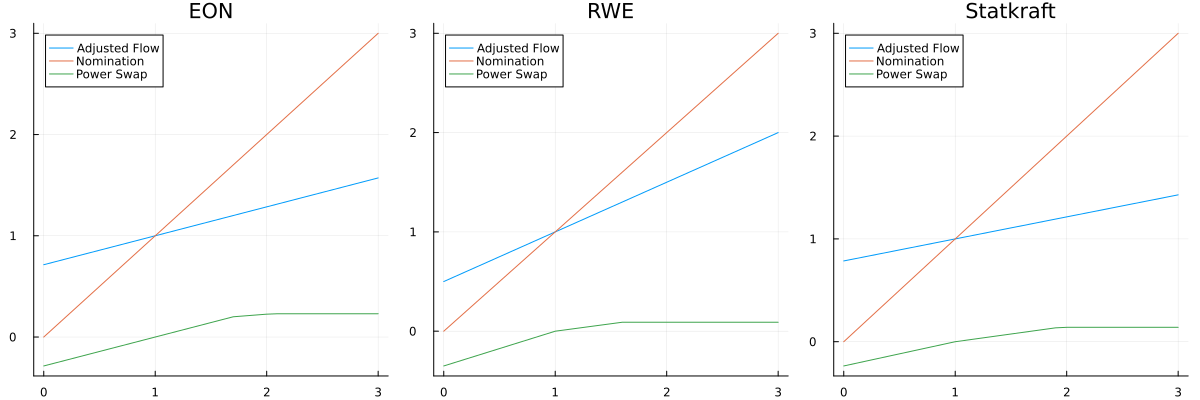

In [35]:
noms = 0:0.1:3

Qadjs = Dict{Participant, Vector{Float64}}(j => [] for j in J1)
P_Swaps = Dict{Participant, Vector{Float64}}(j => [] for j in J1)
println(Qadjs, "\n", P_Swaps)
for i in eachindex(J1)
    println("Producer: ", J1[i])
    Nomination[(participant = J1[1], reservoir = R1[1])] = 1.0
    Nomination[(participant = J1[2], reservoir = R1[1])] = 1.0
    Nomination[(participant = J1[3], reservoir = R1[1])] = 1.0
    Qadj_temps, P_Swap_temps = Nomination_Variation(J1[i], R1[1], Nomination, noms, Qref)
    Qadjs[J1[i]] = Qadj_temps
    P_Swaps[J1[i]] = P_Swap_temps
end

println(Qadjs, "\n", P_Swaps)
p = Plots.plot([plot(noms, [Qadjs[j], noms, P_Swaps[j]], title = j.name, label = ["Adjusted Flow" "Nomination" "Power Swap"], show=false) for j in J1]..., layout = (1,length(J1)), size= (1200,400), show=true)